In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
import struct
from scipy import signal
import pywt
from math import sqrt

%pylab inline

interval = 5
dt = 0.0000001 * interval
fs = 10000000 / interval
start = 250000
end = 350000
fig_size = 20

result = []

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Restoring parameters from saver/AE-cos/SAE
0.9583792686462402 0.9651002883911133
0.9449491500854492 0.9628859758377075
0.931873083114624 0.9631410837173462
0.9323886632919312 0.9602669477462769
0.954795241355896 0.9667185544967651
0.9582439661026001 0.9661678075790405
0.9365139007568359 0.9571073055267334
0.964820146560669 0.9651682376861572
0.9594271183013916 0.9534106254577637
0.9597245454788208 0.9667561054229736
0.958651065826416 0.9605739116668701
0.9304914474487305 0.9566859006881714
0.9448263645172119 0.9624723196029663
0.9461847543716431 0.9643653631210327
0.9406212568283081 0.961361289024353
0.9283939599990845 0.9542796611785889
0.9276226758956909 0.9586969614028931
0.9533164501190186 0.9646520614624023
0.9436414241790771 0.9608433246612549
0.9435770511627197 0.9639934301376343
0.9272418022155762 0

-3.513537883758545 -3.2460983991622925
-3.476407766342163 -3.19403076171875
-3.5315003395080566 -3.444020986557007
-3.528224468231201 -3.0078532695770264
-3.5286595821380615 -2.994147777557373
-3.3244844675064087 -3.2150789499282837
-3.3580615520477295 -3.3385493755340576
-3.629889130592346 -3.2220264673233032
-3.666704535484314 -3.3201589584350586
-3.3997323513031006 -3.3336892127990723
-3.293145537376404 -2.885141611099243
-3.6208781003952026 -3.5443522930145264
-3.607718586921692 -3.2667609453201294
-3.6866917610168457 -3.2420822381973267
-3.0441495180130005 -2.8487720489501953
-3.2796790599823 -3.208242893218994
0.2430734634399414 0.44553256034851074
0.07247483730316162 -0.07474982738494873
0.08590495586395264 -0.04445457458496094
0.28769052028656006 -0.0601574182510376
0.0601503849029541 0.8031711578369141
-1.1892982721328735 -1.4136972427368164
0.3540465831756592 0.20203089714050293
0.4202136993408203 0.601091742515564
-0.22210919857025146 0.012531042098999023
0.7786247730255127 

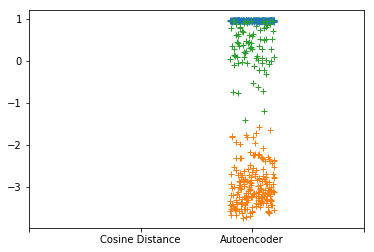

In [2]:
with tf.Session() as sess:  
    
    tf.local_variables_initializer().run()
    tf.global_variables_initializer().run()
    
    coord = tf.train.Coordinator()
    thread = tf.train.start_queue_runners(sess=sess,coord=coord)
    
    saver = tf.train.import_meta_graph('saver/AE-cos/SAE.meta')
    saver.restore(sess,'saver/AE-cos/SAE')  
    y = tf.get_collection('output_y')[0]
    l = tf.get_collection('output_y')[1]
    
    graph = tf.get_default_graph()
    x = graph.get_tensor_by_name("input_x:0")
    
    record = []
    for dd in np.arange(60,101,10):
        count = 0
        while True:
            filepath = "input_data" + "//" + "train1" + "//" + str(dd) + "//" + str(count)

            if os.path.isfile(filepath) == False:
                break

            with open(filepath, "rb") as fb:
                data = fb.read()

            ch1ch2 = struct.unpack("<"+str(int(len(data)/2))+"H", data)
            ch1ch2 = np.array(ch1ch2)
            ch1ch2 = (ch1ch2-8192)*2.5/8192

            datay1 = ch1ch2[::2]
            datay2 = ch1ch2[1::2]

            data1 = datay1[start:end:interval]
            data2 = datay2[start:end:interval]

            wavelet = 'morl'
            c = pywt.central_frequency(wavelet)
            fa = np.arange(400000, 20000 - 1, -20000)
            scales = np.array(float(c)) * fs / np.array(fa)

            [cfs1,frequencies1] = pywt.cwt(data1,scales,wavelet,dt)
            [cfs2,frequencies2] = pywt.cwt(data2,scales,wavelet,dt)
            power1 = (abs(cfs1)) ** 2
            power2 = (abs(cfs2)) ** 2

            length_now = len(power2[0])
            power1 = np.reshape(power1,(len(power1),fig_size,int(length_now/fig_size)))
            power2 = np.reshape(power2,(len(power2),fig_size,int(length_now/fig_size)))
            power1 = np.log10(np.mean(power1,axis=2))
            power2 = np.log10(np.mean(power2,axis=2))

            mx = power1.max()
            mn = power1.min()
            power1 = (power1-mn) / (mx-mn)
            power1 = power1.flatten()

            mx = power2.max()
            mn = power2.min()
            power2 = (power2-mn) / (mx-mn)
            power2 = power2.flatten()

            outputdata1,loss1 = sess.run([y,l],feed_dict ={x:[power1]})
            outputdata2,loss2 = sess.run([y,l],feed_dict ={x:[power2]})
            
            cos_dis1 = 1 - loss1 * 10
            cos_dis2 = 1 - loss2 * 10

            print(cos_dis1,cos_dis2)
            record.append(cos_dis1)
            record.append(cos_dis2)

            count = count + 1
            if count > 20:
                break
    result.append(record)
    
    record = []
    for dd in np.arange(60,101,10):
        count = 0
        while True:
            filepath = "input_data" + "//" + "train_knock" + "//" + str(dd) + "//" + str(count)

            if os.path.isfile(filepath) == False:
                break

            with open(filepath, "rb") as fb:
                data = fb.read()

            ch1ch2 = struct.unpack("<"+str(int(len(data)/2))+"H", data)
            ch1ch2 = np.array(ch1ch2)
            ch1ch2 = (ch1ch2-8192)*2.5/8192

            datay1 = ch1ch2[::2]
            datay2 = ch1ch2[1::2]

            data1 = datay1[start:end:interval]
            data2 = datay2[start:end:interval]

            wavelet = 'morl'
            c = pywt.central_frequency(wavelet)
            fa = np.arange(400000, 20000 - 1, -20000)
            scales = np.array(float(c)) * fs / np.array(fa)

            [cfs1,frequencies1] = pywt.cwt(data1,scales,wavelet,dt)
            [cfs2,frequencies2] = pywt.cwt(data2,scales,wavelet,dt)
            power1 = (abs(cfs1)) ** 2
            power2 = (abs(cfs2)) ** 2

            length_now = len(power2[0])
            power1 = np.reshape(power1,(len(power1),fig_size,int(length_now/fig_size)))
            power2 = np.reshape(power2,(len(power2),fig_size,int(length_now/fig_size)))
            power1 = np.log10(np.mean(power1,axis=2))
            power2 = np.log10(np.mean(power2,axis=2))

            mx = power1.max()
            mn = power1.min()
            power1 = (power1-mn) / (mx-mn)
            power1 = power1.flatten()

            mx = power2.max()
            mn = power2.min()
            power2 = (power2-mn) / (mx-mn)
            power2 = power2.flatten()

            outputdata1,loss1 = sess.run([y,l],feed_dict ={x:[power1]})
            outputdata2,loss2 = sess.run([y,l],feed_dict ={x:[power2]})
            
            cos_dis1 = 1 - loss1 * 10
            cos_dis2 = 1 - loss2 * 10

            print(cos_dis1,cos_dis2)
            record.append(cos_dis1)
            record.append(cos_dis2)

            count = count + 1
            if count > 20:
                break
    result.append(record)
    
    record = []
    for dd in [1]:
        count = 0
        while True:
            filepath = "input_data" + "//" + "other" + "//" + "drop" + "//" + str(count)

            if os.path.isfile(filepath) == False:
                break

            with open(filepath, "rb") as fb:
                data = fb.read()

            ch1ch2 = struct.unpack("<"+str(int(len(data)/2))+"H", data)
            ch1ch2 = np.array(ch1ch2)
            ch1ch2 = (ch1ch2-8192)*2.5/8192

            datay1 = ch1ch2[::2]
            datay2 = ch1ch2[1::2]

            data1 = datay1[start:end:interval]
            data2 = datay2[start:end:interval]

            wavelet = 'morl'
            c = pywt.central_frequency(wavelet)
            fa = np.arange(400000, 20000 - 1, -20000)
            scales = np.array(float(c)) * fs / np.array(fa)

            [cfs1,frequencies1] = pywt.cwt(data1,scales,wavelet,dt)
            [cfs2,frequencies2] = pywt.cwt(data2,scales,wavelet,dt)
            power1 = (abs(cfs1)) ** 2
            power2 = (abs(cfs2)) ** 2

            length_now = len(power2[0])
            power1 = np.reshape(power1,(len(power1),fig_size,int(length_now/fig_size)))
            power2 = np.reshape(power2,(len(power2),fig_size,int(length_now/fig_size)))
            power1 = np.log10(np.mean(power1,axis=2))
            power2 = np.log10(np.mean(power2,axis=2))

            mx = power1.max()
            mn = power1.min()
            power1 = (power1-mn) / (mx-mn)
            power1 = power1.flatten()

            mx = power2.max()
            mn = power2.min()
            power2 = (power2-mn) / (mx-mn)
            power2 = power2.flatten()

            outputdata1,loss1 = sess.run([y,l],feed_dict ={x:[power1]})
            outputdata2,loss2 = sess.run([y,l],feed_dict ={x:[power2]})
            
            cos_dis1 = 1 - loss1 * 10
            cos_dis2 = 1 - loss2 * 10

            print(cos_dis1,cos_dis2)
            record.append(cos_dis1)
            record.append(cos_dis2)

            count = count + 1
            if count > 40:
                break
    result.append(record)
    
    
    coord.request_stop()
    coord.join(thread)
    
    
ax = plt.subplot(1,1,1)

for index in range(len(result)):
    record_x = []
    for y in range(len(result[index])):
        record_x.append(2 + np.random.uniform(-0.2,0.2))
    plt.plot(record_x,result[index],'+')

plt.xlim(0,3)
#plt.ylim(0,1)
xmajorLocator = MultipleLocator(1)
ax.xaxis.set_major_locator(xmajorLocator)
names = ["","Cosine Distance","Autoencoder",""]
plt.xticks([0,1,2,3],names)

plt.show()